## **CAM, Grad-CAM 구현하기** 

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import Image
import copy


print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.9.0
1.22.3
4.6.0
9.5.0


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

### **(1) 데이터셋 준비하기**  
  
https://www.tensorflow.org/datasets/catalog/stanford_dogs

**train : 2,000장**   
**test : 8,580장**

|Feature       |	Class    |	Shape          |	Dtype|	Description|
|        ---   | ---         |---              |---      |---          |
|              |FeaturesDict |                 |         |             |			
|image         |	Image    |	(None, None, 3)|uint8    |	           |
|image/filename|	Text     |                 |string   |	           |
|label         |ClassLabel   | 	               |	int64|	           |
|objects       |Sequence     |                 |         |             |			
|objects/bbox  |BBoxFeature  |	(4,)           |float32  |             |	  
  
  

**FeaturesDict로 감싸져있고, 'image', 'image/filename', 'label', 'objects' 총 4개의 keys를 가짐.**

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='/Users/yena/tensorflow_datasets'
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-29 20:47:36.797989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-29 20:47:36.798118: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-06-29 20:47:36.852690: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


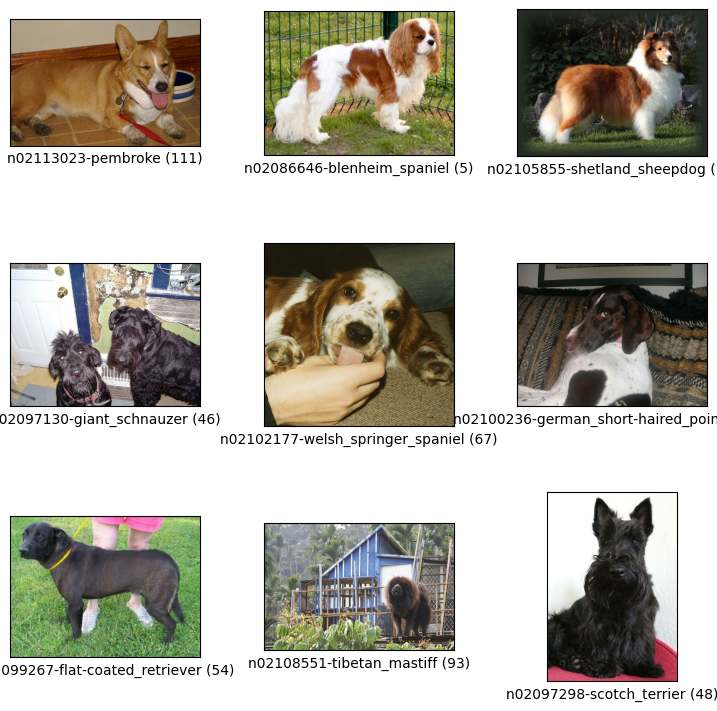

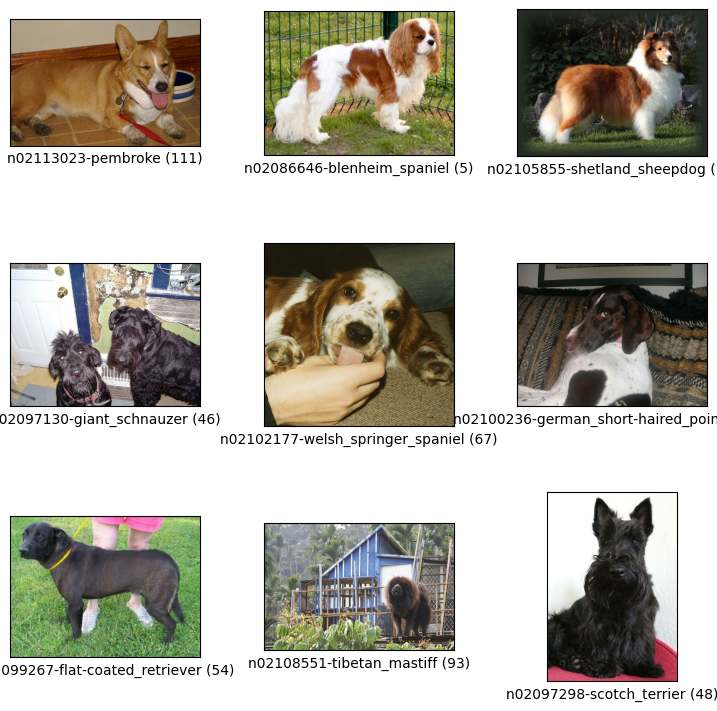

In [4]:
tfds.show_examples(ds_train, ds_info)

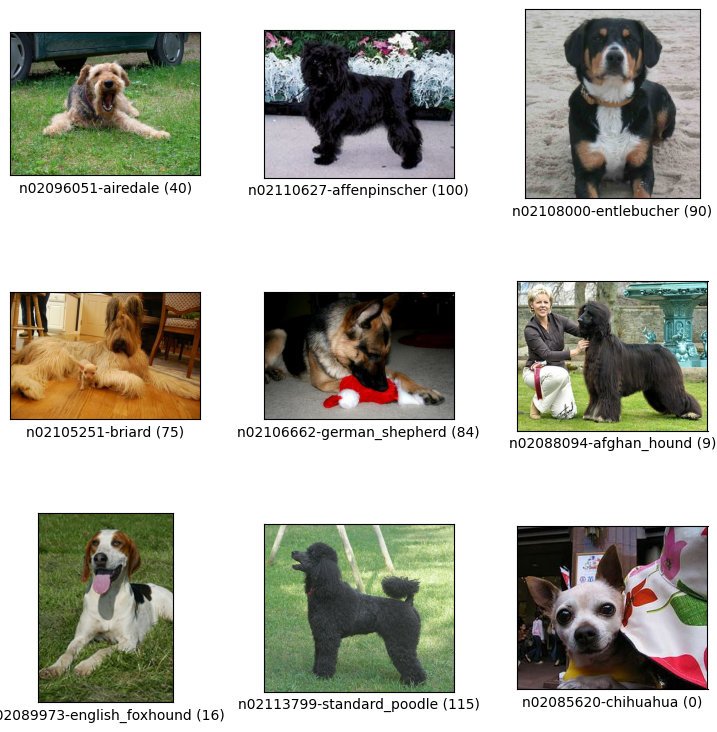

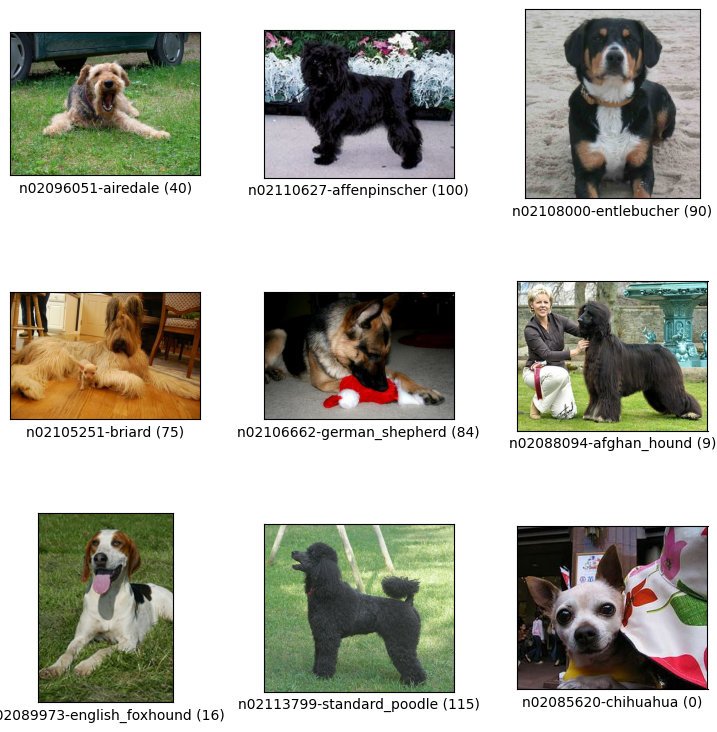

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

**[bbox]**  
- tf.Tensor of type tf.float32 and shape [4,] which contains the normalized coordinates of the bounding box [ymin, xmin, ymax, xmax]    
  
- height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미함

---

### **(2) CAM을 위한 모델 만들기**




![]()
<img src="https://imgur.com/PmOTTzT.png" width="500px" height="300px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>    


![]()
<img src="https://imgur.com/7XdLYt8.png" width="300px" height="80px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>    

**[CAM]**   
  
CNN → 특성맵 → GAP → softmax layer(softmax를 가지고 bias가 없는 fully connected layer)를 적용


In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(120, activation='softmax', use_bias=False)(x)    
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

**Q. CAM에서 사용하는 특성 맵은?**  
  
- conv5_block3_out의 output. 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행
  


---

### **(3) 데이터 전처리**

In [9]:
# 전처리 수행
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

# 전체 전처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [10]:
# 데이터 전처리
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)


In [11]:
# 구성된 배치 모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


---

### **(4) CAM**

저장한 가중치를 활용해 CAM, Grad-CAM을 생성

In [12]:
# CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어짐
# 데이터셋에서 한 장씩 뽑는 함수
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


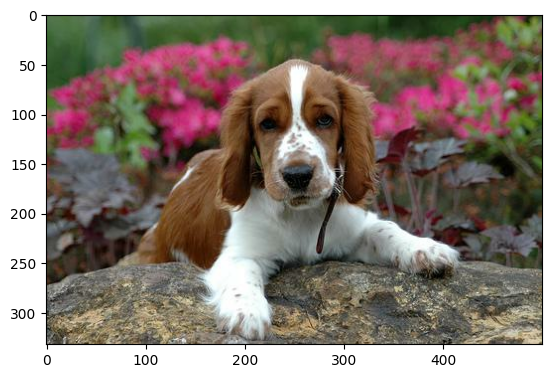

In [13]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [14]:
# 저장된 모델 불러오기
cam_model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

**[CAM을 생성하기 위해 필요한 것]**  
- (1) 특성 맵  
- (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치  
- (3) 원하는 클래스의 출력값  
  
- 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하기 위해 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화  
model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환해야 함


In [15]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output 에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation : 마지막 layer
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적 : 활성화된 정도
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image


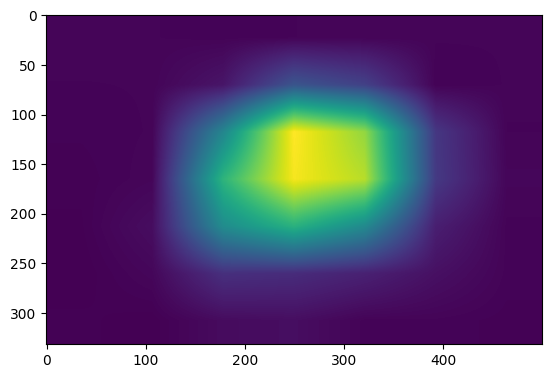

In [16]:
# CAM 이미지 생성
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

[두 개의 이미지 더하기, 블렌딩]  
https://webnautes.tistory.com/1245 

In [17]:
# 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

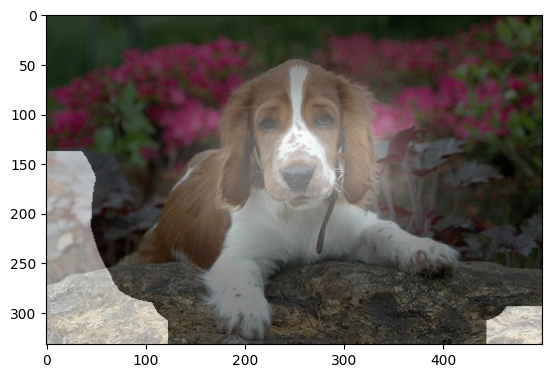

In [18]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

---

### **(5) Grad-CAM**

108


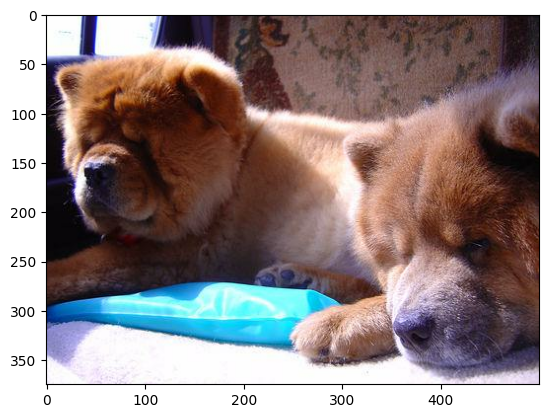

In [19]:
# 새로운 이미지
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

**[Grad-CAM]**
  
- 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델 재활용 가능
  
- 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 gradient에 GAP 연산을 적용 -> 관찰 대상이 되는 layer의 채널별 가중치를 구함  
- 최종 CAM 이미지를 구하기 위해서 레이어의 채널별 가중치와 레이어에서 나온 채널별 특성 맵을 가중합 -> cam_image


In [20]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 특정 레이어의 output이 필요함 -> 모델의 input과 output을 새롭게 정의
    # 어떤 레이어든 CAM 이미지를 뽑을 수 있음.
    # 관찰 대상 레이어의 이름으로 activation_layer를 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용
    # : 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용하기 때문
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(정답으로 활용) 예측값
        output = conv_output[0] # 원하는 layer의 output
        grad_val = tape.gradient(loss, conv_output)[0] # pred와 output 사이의 gradient << 가중치로 활용

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적 : class activation map
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


**Grad-CAM 이미지 확인**

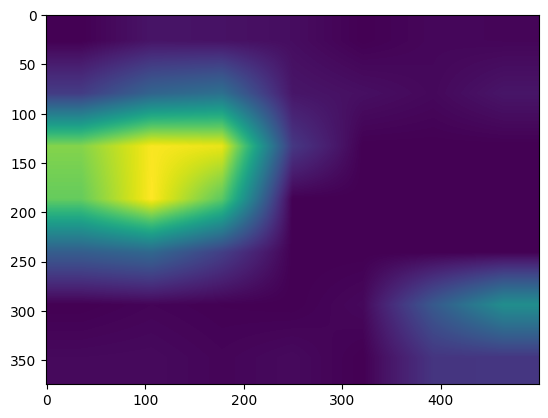

In [21]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

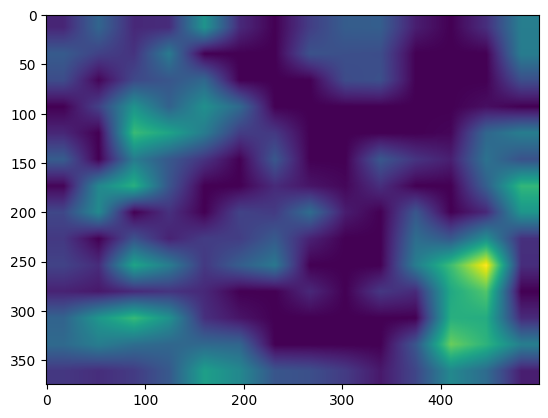

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

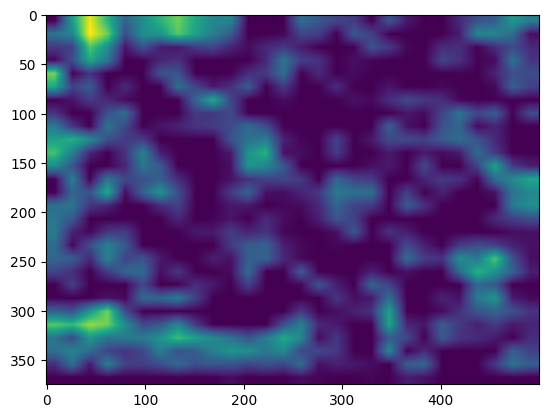

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

---

### **(6) 바운딩 박스 구하기**

In [24]:
# 바운딩 박스 만들기
def get_bbox(cam_image, score_thresh=0.05):     # score_thresh 이하의 바운딩 박스는 제거
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # findContours(), minAreaRect()로 사각형 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    # boxPoints()로 꼭지점 찾기
    rect = cv2.boxPoints(rotated_rect)
    # int 자료형으로 변환
    rect = np.int0(rect)
    return rect

67


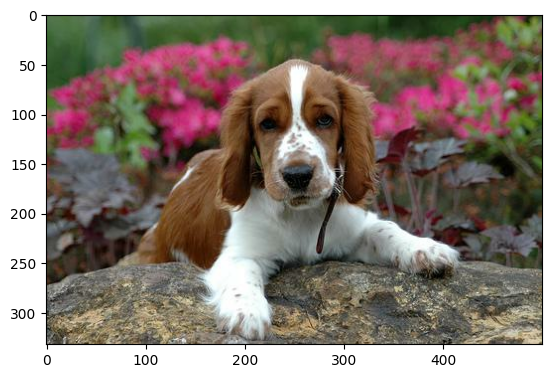

In [25]:
# 새로운 이미지
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [26]:
cam_image = generate_cam(cam_model, item)
grad3_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
grad5_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

In [27]:
# CAM
rect = get_bbox(cam_image)
rect

array([[111,  33],
       [443,  33],
       [443, 294],
       [111, 294]])

In [28]:
# Grad-CAM(conv3_block3_out)
grad3_rect = get_bbox(grad3_cam_image)
grad3_rect

array([[383, 331],
       [383, 325],
       [384, 325],
       [384, 331]])

In [29]:
# Grad-CAM(conv3_block3_out)
grad5_rect = get_bbox(grad5_cam_image)
grad5_rect

array([[ 79,  72],
       [409, -27],
       [471, 172],
       [140, 273]])

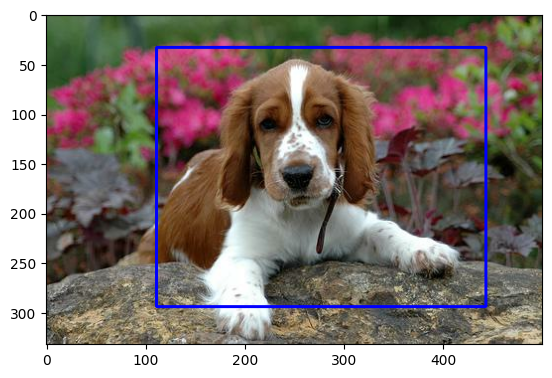

In [30]:
# CAM 바운딩 박스 시각화
cam_image = copy.deepcopy(item['image'])
cam_image = cv2.drawContours(cam_image, [rect], 0, (0,0,255), 2)
plt.imshow(cam_image)
plt.show()

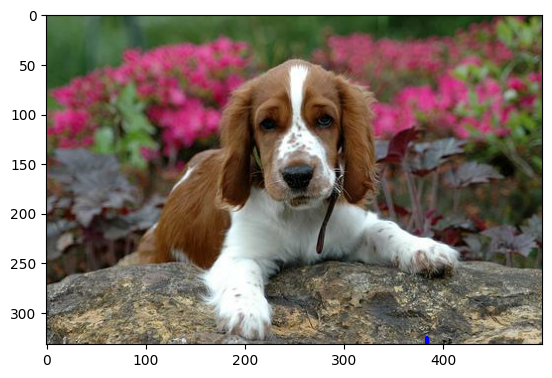

In [31]:
# Grad-CAM(conv3_block3_out) 바운딩 박스 시각화
grad3_image = copy.deepcopy(item['image'])
grad3_image = cv2.drawContours(grad3_image, [grad3_rect], 0, (0,0,255), 2)
plt.imshow(grad3_image)
plt.show()

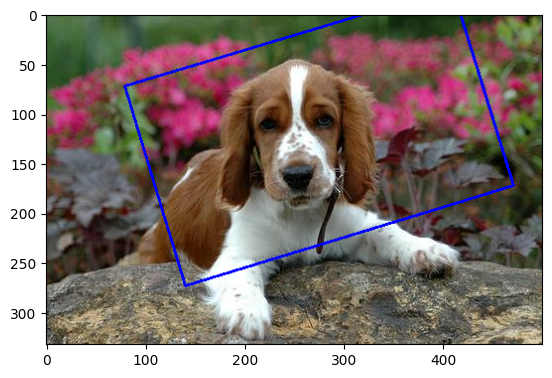

In [32]:
# Grad-CAM(conv5_block3_out) 바운딩 박스 시각화
grad5_image = copy.deepcopy(item['image'])
grad5_image = cv2.drawContours(grad5_image, [grad5_rect], 0, (0,0,255), 2)
plt.imshow(grad5_image)
plt.show()

---

### **(7) IoU 구하기**

- 두 영역의 교집합(intersection) 영역의 넓이/ 두 영역의 합집합인(union) 영역  
  
- 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있음  
- 0~1 사이의 값. 1에 가까울 수록 정확한 것으로 판단. 주로 0.5를 임계치로 사용

In [33]:
# rect를 minmax bbox 형태로 치환하는 함수
# rect의 좌표는 (x, y) 형태
# bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [34]:
# CAM
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.222, 0.8855421686746988, 0.886]

In [35]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [36]:
# Grad-CAM(conv3_block3_out)
grad3_pred_bbox = rect_to_minmax(grad3_rect, item['image'])
grad3_pred_bbox

[0.9789156626506024, 0.766, 0.9969879518072289, 0.768]

In [37]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [38]:
# Grad-CAM(conv5_block3_out)
grad5_pred_bbox = rect_to_minmax(grad5_rect, item['image'])
grad5_pred_bbox

[-0.08132530120481928, 0.158, 0.822289156626506, 0.942]

In [39]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [40]:
# IoU 구하는 함수
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    iou = iou.round(4)
    
    return iou

In [41]:
# CAM IoU
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6984

In [42]:
# Grad-CAM(conv3_block3_out) IoU
get_iou(grad3_pred_bbox, item['objects']['bbox'][0])

0.0

In [43]:
# Grad-CAM(conv5_block3_out) IoU
get_iou(grad5_pred_bbox, item['objects']['bbox'][0])

0.5532

### **[IoU 비교]**  
  
|     | CAM  | Grad-CAM(conv3_block3_out) | Grad-CAM(conv5_block3_out) |
|:---:|:---: |:---:                       |:---:                       |
|IoU  |0.6984|      0.0                   |  0.5532                  |


**conv3_block3_out(Grad-CAM) < conv5_block3_out(Grad-CAM) < 최종 레이어(CAM) 순으로 IoU가 점차 증가하는 것을 확인할 수 있었으며,**  
**conv5_block3_out과 최종 레이어의 IoU값은 각각 0.5532, 0.6984로 일반적인 IoU 임계치인 0.5 이상으로 나타나 해당 모델이 영역을 잘 찾았다고 할 수 있다.**